In [2]:
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers.utils import load_image
from PIL import Image
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#!pip install controlnet_aux==0.0.7

In [4]:
import torch
import os
from huggingface_hub import HfApi
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
import numpy as np
from controlnet_aux import PidiNetDetector, HEDdetector

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
)

checkpoint = "lllyasviel/control_v11p_sd15_softedge"


processor = HEDdetector.from_pretrained('lllyasviel/Annotators')
processor = PidiNetDetector.from_pretrained('lllyasviel/Annotators')

controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-normal", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

generator = torch.manual_seed(0)



/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an e

In [72]:
from transformers import pipeline
depth_estimator = pipeline("depth-estimation", model ="Intel/dpt-hybrid-midas" )

def get_normal_map_estimation(depth_image):
    # image = depth_estimator(image)['predicted_depth'][0]
    #image = image.numpy()
    image = depth_image
    image_depth = image.copy()
    print(image_depth.shape)
    image_depth -= np.min(image_depth)
    image_depth /= np.max(image_depth)

    bg_threhold = 0.0

    x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=15)
    x[image_depth < bg_threhold] = 0

    y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=15)
    y[image_depth < bg_threhold] = 0

    z = np.ones_like(x) * np.pi * 2.0

    image = np.stack([x, y, z], axis=2)
    image /= np.sum(image ** 2.0, axis=2, keepdims=True) ** 0.5
    image = (image * 127.5 + 127.5).clip(0, 255).astype(np.uint8)
    image = Image.fromarray(image)
    return image 

(384, 384)
(512, 512)


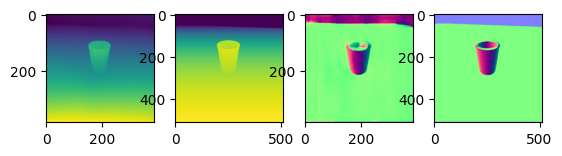

In [81]:

from dsd import DATA_DIR


render_path = DATA_DIR / "renders/mugs/2024-01-29_10-54-50/ACE_Coffee_Mug_Kristen/001"
rgb_image = Image.open(render_path / "rgb.png")
rgb_image = load_image(rgb_image)
depth_image = load_image(Image.open(render_path / "depth_image.png"))
estimated_normal_map = get_normal_map_estimation(depth_estimator(rgb_image)['predicted_depth'][0].numpy())
normal_map = load_image(Image.open(render_path / "normal_image.png"))

depth_map = 1- (np.array(depth_image).astype(np.float32)/255)[...,0]
depth_map = depth_map - np.min(depth_map)
depth_map = depth_map / np.max(depth_map)

estimated_depth_map = depth_estimator(rgb_image)['predicted_depth'][0].numpy()

normal_map = get_normal_map_estimation(depth_map)

# show original image, depth image and normal map
plt.subplot(1, 4, 1)
plt.imshow(estimated_depth_map)
plt.subplot(1, 4, 2)
plt.imshow(depth_map)
plt.subplot(1, 4, 3)
plt.imshow(estimated_normal_map)
plt.subplot(1, 4, 4)
plt.imshow(normal_map)






[-1. -1.  1.]
[[ 1.66596172e-01 -9.86025206e-01  1.06702979e-07]
 [ 6.22080878e-01  1.05105198e-01  7.75866108e-01]
 [-7.65023559e-01 -1.29256261e-01  6.30897567e-01]]
[-0.89702949  0.43397326 -0.0836977 ]


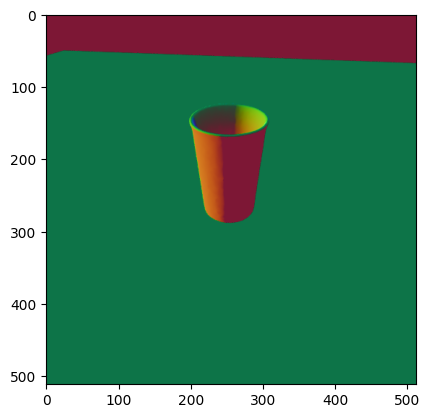

In [78]:
normal_map = load_image(Image.open(render_path / "normal_image.png"))
normal_map = np.array(normal_map).astype(np.float32)
normal_map = normal_map / 255
plt.imshow(normal_map)

pose = np.load(render_path / "mug_pose_in_camera_frame.npy")
r = pose[:3, :3]

# change normal map from world coordinates to camera coordinates
# first need to convert colors back to vectors
normal_map = normal_map * 2 - 1
# normalize each vector
print(normal_map[100,100])
print(r)
normal_map = normal_map / np.linalg.norm(normal_map, axis=2, keepdims=True)
# rotate vectors

normal_map = np.einsum("ij, ...j", np.linalg.inv(r), normal_map)
normal_map = normal_map / np.linalg.norm(normal_map, axis=2, keepdims=True)
print(normal_map[100,100])

normal_map[...,1] *= -1
normal_map = normal_map * 0.5 + 0.5
normal_map = normal_map[...,[0,2,1]]
plt.imshow(normal_map)
normal_map.shape
normal_map = Image.fromarray((normal_map * 255).astype(np.uint8))

In [82]:
prompt = "blue mug on a white table"

images = pipe(prompt, num_inference_steps=20, generator=generator, image=normal_map, num_images_per_prompt=4,controlnet_conditioning_scale=1.0).images


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


Text(0.5, 1.0, 'Prompted 4')

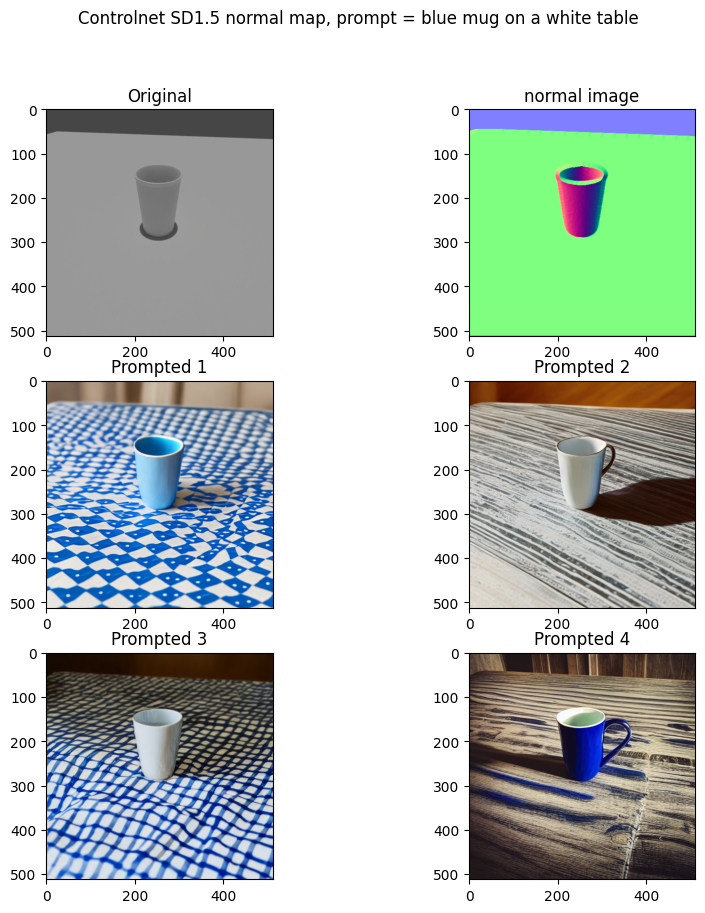

In [83]:
## show results next to the original image and the cannied image
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
# set the title
fig.suptitle(f"Controlnet SD1.5 normal map, prompt = {prompt}")
axs[0, 0].imshow(rgb_image)
axs[0, 0].set_title("Original")
axs[0, 1].imshow(normal_map)
axs[0, 1].set_title("normal image")
axs[1, 0].imshow(images[0])
axs[1, 0].set_title("Prompted 1")
axs[1, 1].imshow(images[1])
axs[1, 1].set_title("Prompted 2")
axs[2, 0].imshow(images[2])
axs[2, 0].set_title("Prompted 3")
axs[2, 1].imshow(images[3])
axs[2, 1].set_title("Prompted 4")